*Group 30 Contributers: Zhong Tan, Nicholas Low, Stephen Huang，Liu Ruiqi* 

*To group 30 members: add your name here as proof of contribution*

To edit, go inside Jupyter. Click the diamond icon on the left bar. Click the cloud down arrow. Edit changes. Save. The project is now under [Changed]. Hover over it and click on the [+]. Fill in the summary with what you changed. Click [COMMIT]. Click the cloud up arrow. Everything is now updated.

**Using R and knn regression to predict used car costs in the US based on mileage and year**

**Introduction**

Being able to predict used car prices can save families thousands of dollars. By using the progam language R, we can plot graphs and get a prediction for how much a car may cost, using a method called regression to predict a numerical value for a used car's price based on factors we enter.

We will be predicting the cost of a used car based on mileage and year. As background knowledge, we know that a substantial factor in car price is the year of its production. Newer generations of cars carrying more recent technology tend to cost more in comparison to older products with less features. We will apply this knowledge to used cars in our prediction. Another considerable factor is the condition that the car is sold in. Used cars that have been in use for longer periods of time are often in worse condition in used cars that have been used less. These products that have been used extensively are generally valued less than their counterparts that are in better conditions. With this in mind, we will be choosing mileage, a determinant of the condition of the car, as the second variable for our model and predictions.

In order to make predictions on car prices, we will want to determine the best regression model, KNN or linear for the data set. To do so, we will need to visualize our models first to find the optimal k-value. We will be using American used car prices obtained from the web as the dataset for this experiment and have placed it into our group's repository for easy access. To extract this dataset, we will start with read_csv() of our comma seperated sheet in .csv format, USA_cars_datasets.csv.

**Methods and Results**

We will compare which regression model will make more sense, linear or KNN. We will visualize the models on graphs first. After, we will predict the cost for a 2015 car with 100,000 miles. We'll load our libraries.

In [1]:
install.packages("tidyverse")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)
library(tidymodels)
library(GGally)
library(ISLR)
set.seed(0)
options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Okay, let's see our data.

In [3]:
car <- read_csv("https://raw.githubusercontent.com/zhtgeneral/Group-30-Official/main/Data/USA_cars_datasets.csv")
head(car)

New names:
• `` -> `...1`
Rows: 2499 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): brand, model, title_status, color, vin, state, country, condition
dbl (5): ...1, price, year, mileage, lot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
0,6300,toyota,cruiser,2008,clean vehicle,274117,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,2899,ford,se,2011,clean vehicle,190552,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,5350,dodge,mpv,2018,clean vehicle,39590,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,25000,ford,door,2014,clean vehicle,64146,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,27700,chevrolet,1500,2018,clean vehicle,6654,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left
5,5700,dodge,mpv,2018,clean vehicle,45561,white,2c4rdgeg9jr237989,167655771,texas,usa,2 days left


Our columns are number, price, brand, model, year, title, mileage, color, vin, lot, state, country and condition. We have 1 variable per column. We notice that we have 1 observation per row. This means we have a tidy dataset.

Since we're only looking at mileage and year, we will select those columns.

In [4]:
car <- car |>
       select(price, year, mileage)
head(car)

price,year,mileage
<dbl>,<dbl>,<dbl>
6300,2008,274117
2899,2011,190552
5350,2018,39590
25000,2014,64146
27700,2018,6654
5700,2018,45561


This is our reduced data. With only 3 columns, it will be easier to work on. Let's get an idea for the relationship between these variables. 

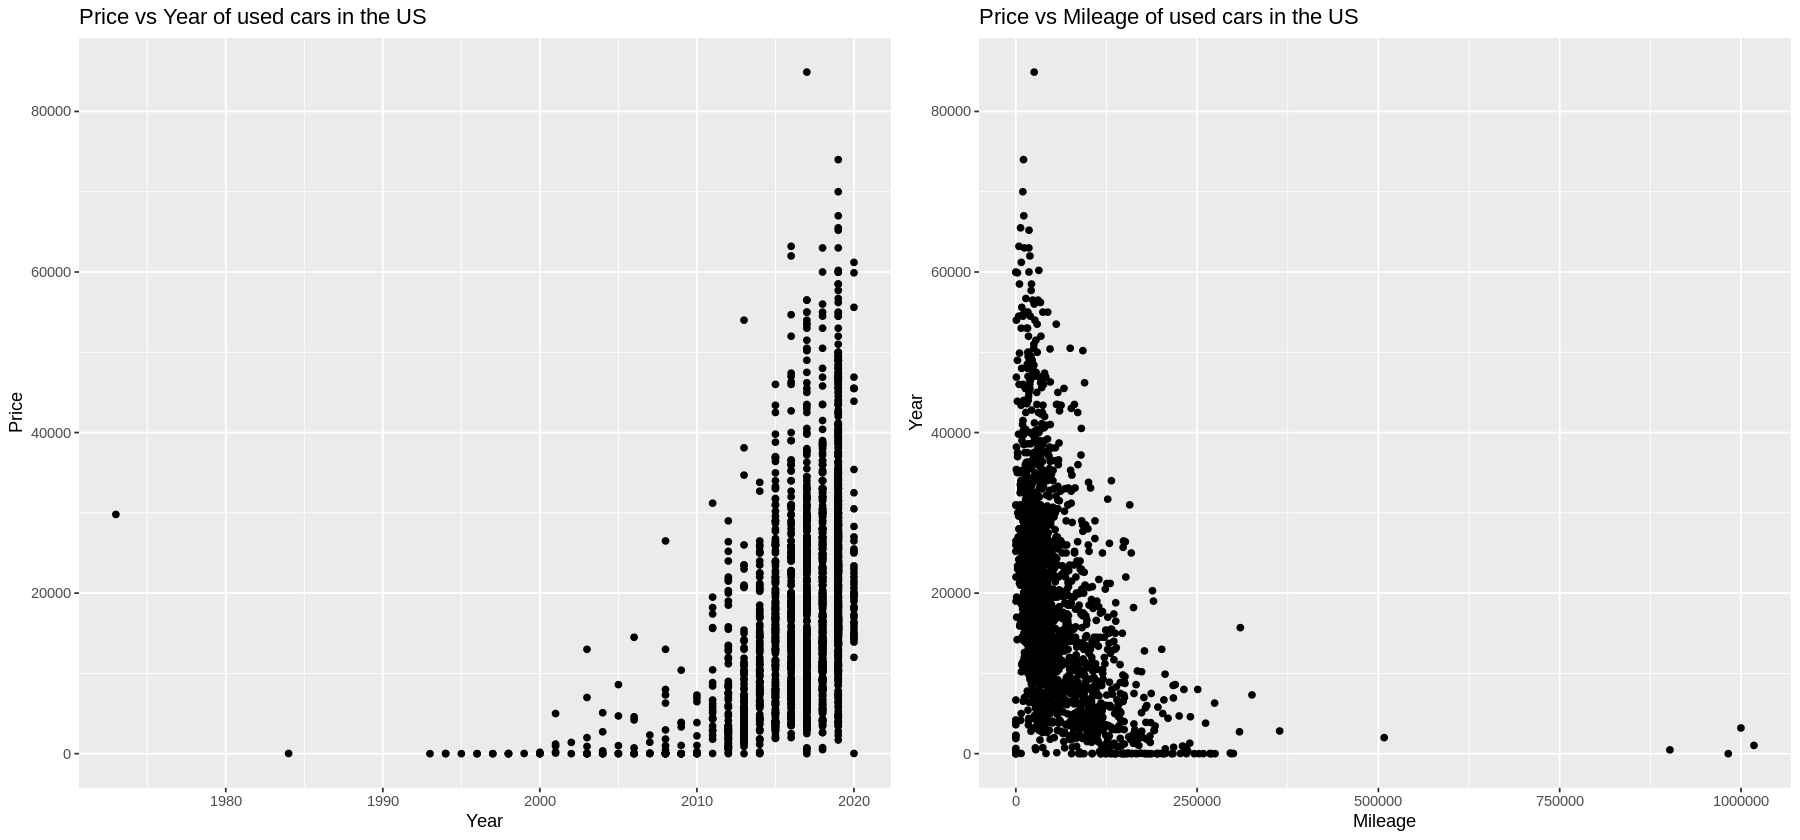

In [5]:
options(repr.plot.width = 15, repr.plot.height = 7)
car_year <- car |>
            ggplot(aes(x = year, y = price)) +
            geom_point() +
            labs(x = "Year",
                 y = "Price",
                 title = "Price vs Year of used cars in the US")
car_mileage <- car |>
            ggplot(aes(x = mileage, y = price)) +
            geom_point() +
            labs(x = "Mileage",
                 y = "Year",
                 title = "Price vs Mileage of used cars in the US")
plot_grid(car_year, car_mileage, ncol = 2)

It looks like we have some outliers that might skew our data. Let's filter so we get rid of cars made before 1990 and mileage to below 500,000 miles.

In [6]:
car_all <- car |>
           select(price, year, mileage) |>
           filter(year > 1990,
                  mileage < 500000)
car_all

price,year,mileage
<dbl>,<dbl>,<dbl>
6300,2008,274117
2899,2011,190552
5350,2018,39590
25000,2014,64146
⋮,⋮,⋮
9200,2018,34553
9200,2018,31594
9200,2018,32557
9200,2018,31371


Let's get a visual representation of these plots.

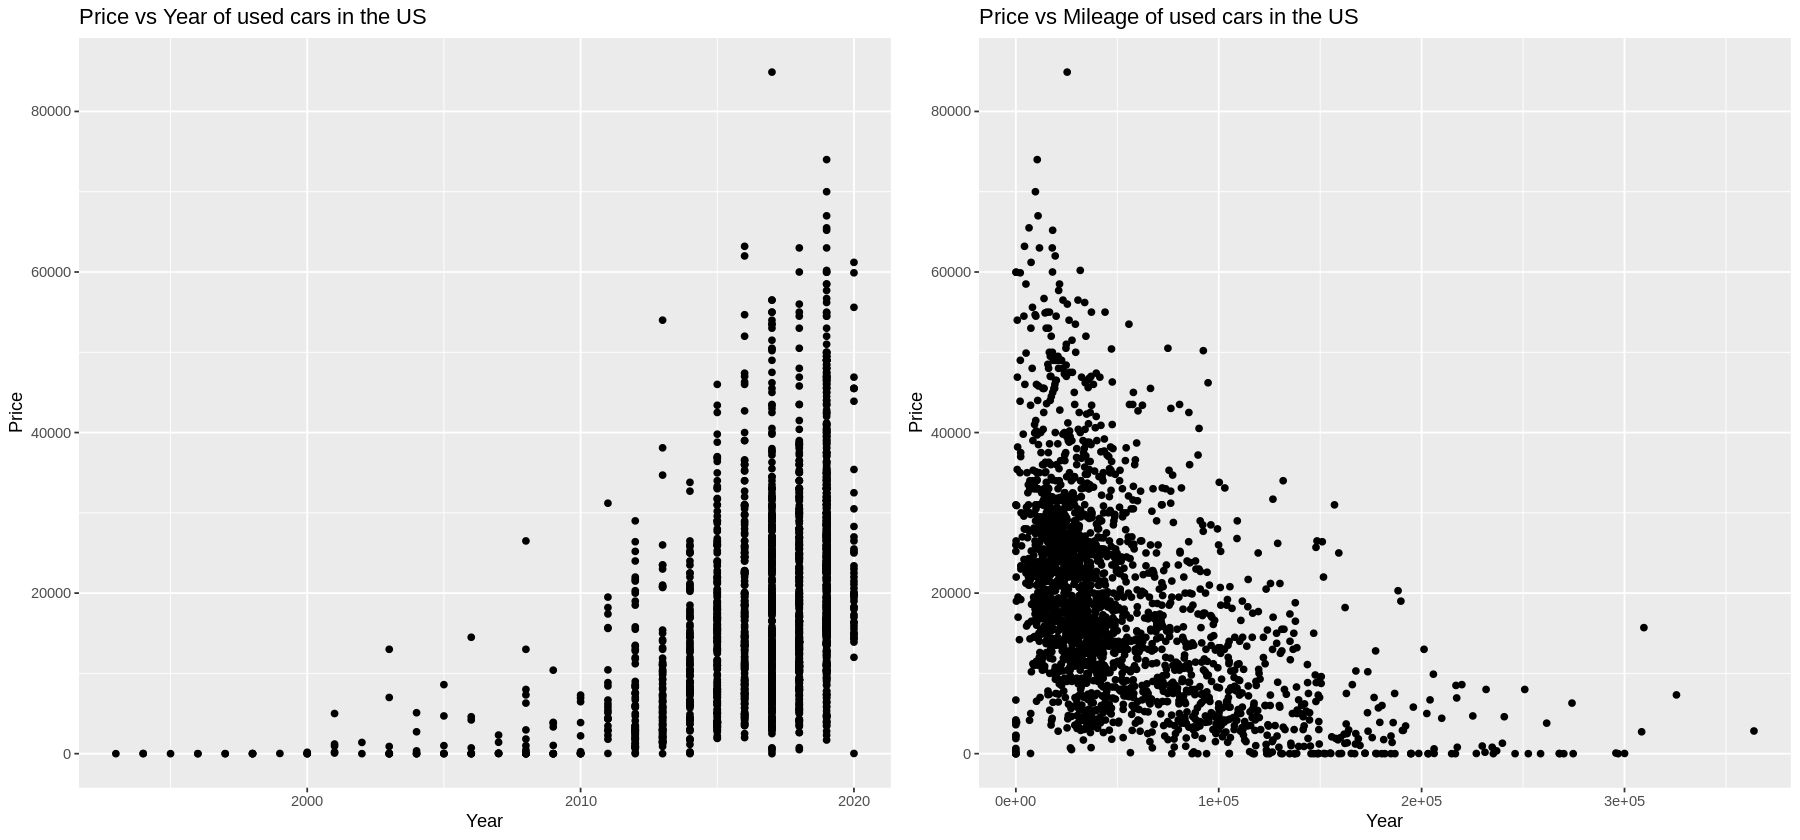

In [7]:
fcar_year <- car_all |>
            ggplot(aes(x = year, y = price)) +
            geom_point() +
            labs(x = "Year",
                 y = "Price",
                 title = "Price vs Year of used cars in the US")

fcar_mileage <- car_all |>
            ggplot(aes(x = mileage, y = price)) +
            geom_point() +
            labs(x = "Year",
                 y = "Price",
                 title = "Price vs Mileage of used cars in the US")

plot_grid(fcar_year, fcar_mileage, ncol = 2)

These are our graphs with outliers removed. Outliers are removed so they don't interfere with our engines. We can see how price and mileage affect price. Newer used cars cost more. Worn cars cost less. Let's use ggpairs to visualize this again.

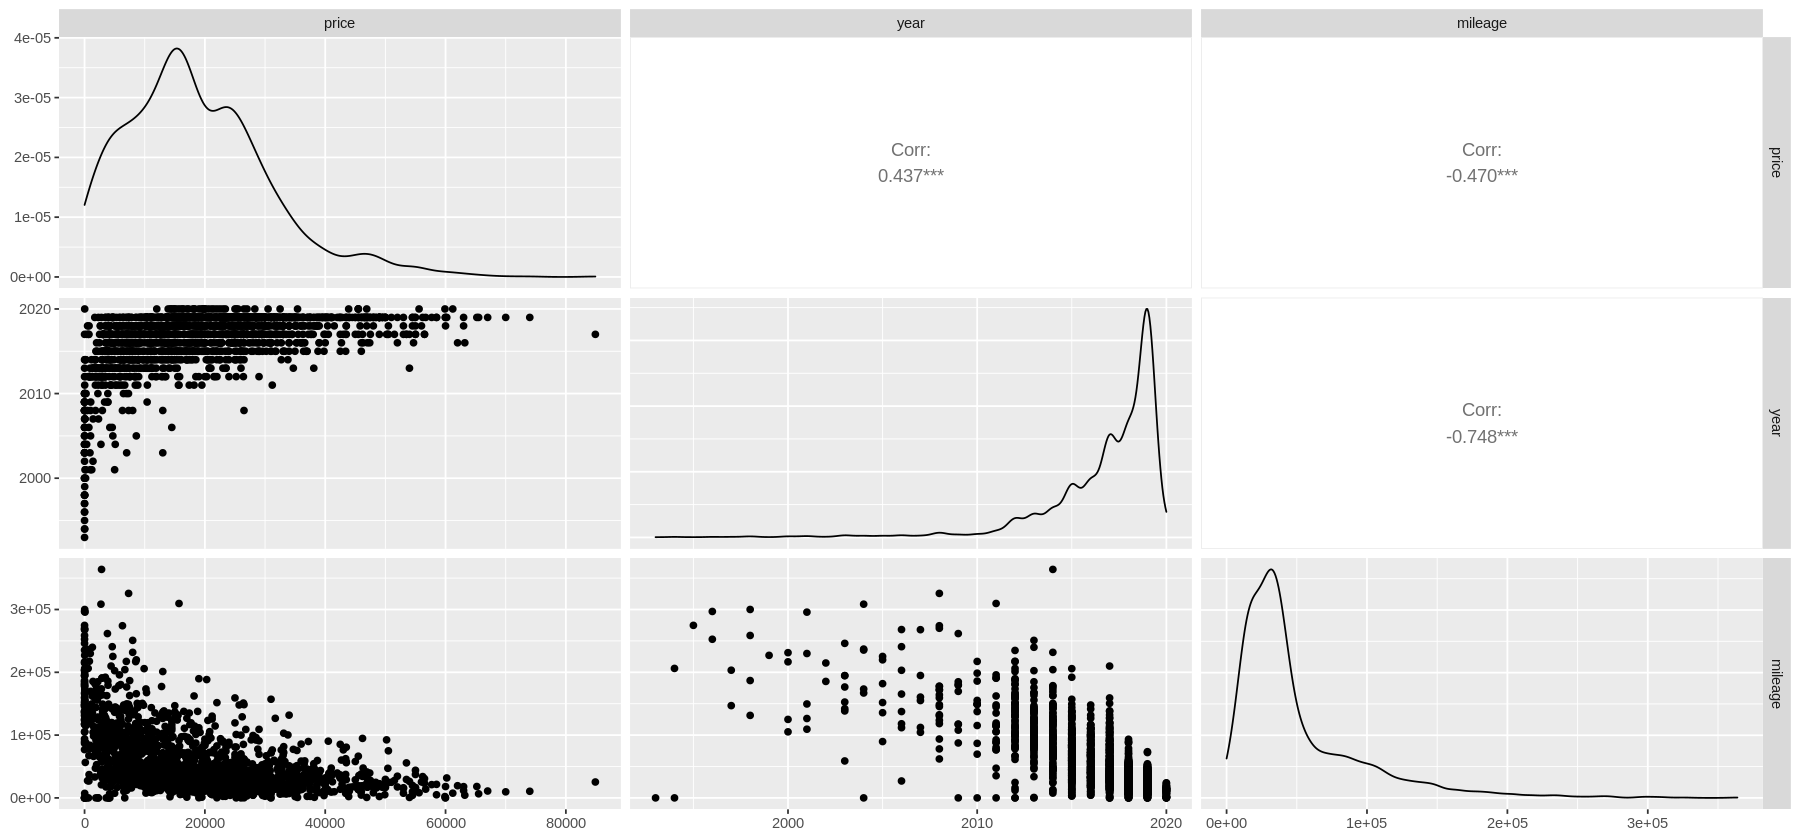

In [8]:
car_all_plot <- car_all |>
                ggpairs()
car_all_plot

This is how the variables in our data affect each other. One interesting thing we find is that newer used cars tend to have lower mileage (bottom middle). For predicting price, it seems plausible to use linear regression to represent the trends. Let's plot both KNN and linear regression to see which model makes most sense.

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 36 rows containing missing values (geom_smooth).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 35 rows containing missing values (geom_smooth).”


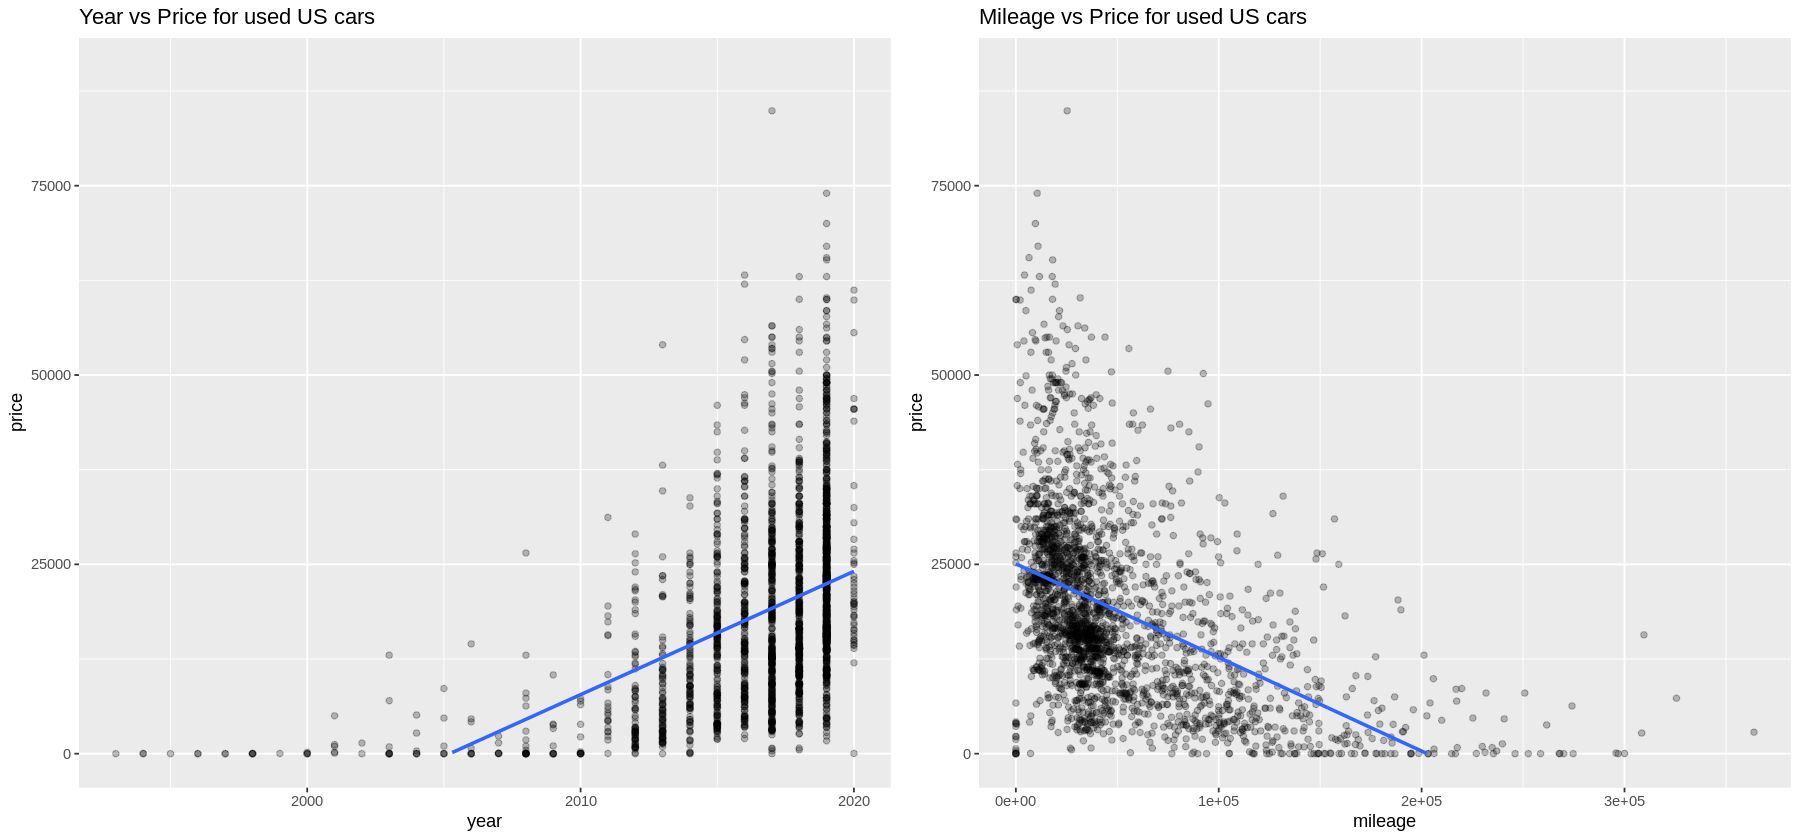

In [9]:
#-----------------------------------------------------------------# Splitting up our data into 2 sets

car_split <- initial_split(car_all, prop = 0.75, strata =price)
car_train <- training(car_split)
car_test <- testing(car_split)

#------------------------------------------------------------------------# Creating our linear regression model

car_recipe <- recipe(price ~ mileage, year, data = car_train) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())

lin_spec <- linear_reg() |>
            set_engine("lm") |>
            set_mode("regression")

lin_fit <- workflow() |>
           add_recipe(car_recipe) |>
           add_model(lin_spec) |>
           fit(data = car_train)

lin_car_results <- lin_fit |>
                   predict(car_test) |>
                   bind_cols(car_test) |>
                   metrics(truth = price, estimate = .pred) |>
                   filter(.metric == "rmse") |>
                   pull()

#-------------------------------# Setting the plot sizes

options(repr.plot.width = 15)

#-------------------------------# Plot for year vs price linear regression

ln_year_plot <- car_all |>
            ggplot(aes(x = year, y = price)) +
            geom_point(alpha = 0.25) +
            geom_smooth(method = "lm", se = FALSE) +
            ylim(0, 90000) +
            labs(title = "Year vs Price for used US cars")

#-------------------------------# Plot for mileage vs price linear regression

ln_mi_plot <- car_all |>
            ggplot(aes(x = mileage, y = price)) +
            geom_point(alpha = 0.25) +
            geom_smooth(method = "lm", se = FALSE) +
            ylim(0, 90000) +
            labs(title = "Mileage vs Price for used US cars")

#--------------------------------------------------------------------# Putting the plots together

plot_grid(ln_year_plot, ln_mi_plot, ncol = 2)

These are our linear regressions models plotted against our data. The blue line is the estimation of a car's cost. We think it is inaccurate because it predicts that some cars are completely free. We think that KNN regression would work better. We'll find the best k value from 1 to 500 using vfolds = to 5 for our KNN regression.

In [10]:
#--------------------------------------------------------------# Setting up K values for KNN regression

tune_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("regression")

knn_vfold <- vfold_cv(car_train, v = 5, strata = price)

knn_fit <- workflow() |>
           add_recipe(car_recipe) |>
           add_model(tune_spec)

grid_vals <- tibble(neighbors = seq(from = 1, to = 500, by = 50))

knn_car_results <- knn_fit |>
                    tune_grid(resamples = knn_vfold, grid = grid_vals) |>
                    collect_metrics() |>
                    filter(.metric == "rmse") |>
                    filter(mean == min(mean))
knn_car_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
201,rmse,standard,10335.15,5,244.709,Preprocessor1_Model05


We see that we want k = 201 in our Knn regression. Let's put it in and see the model on a graph.

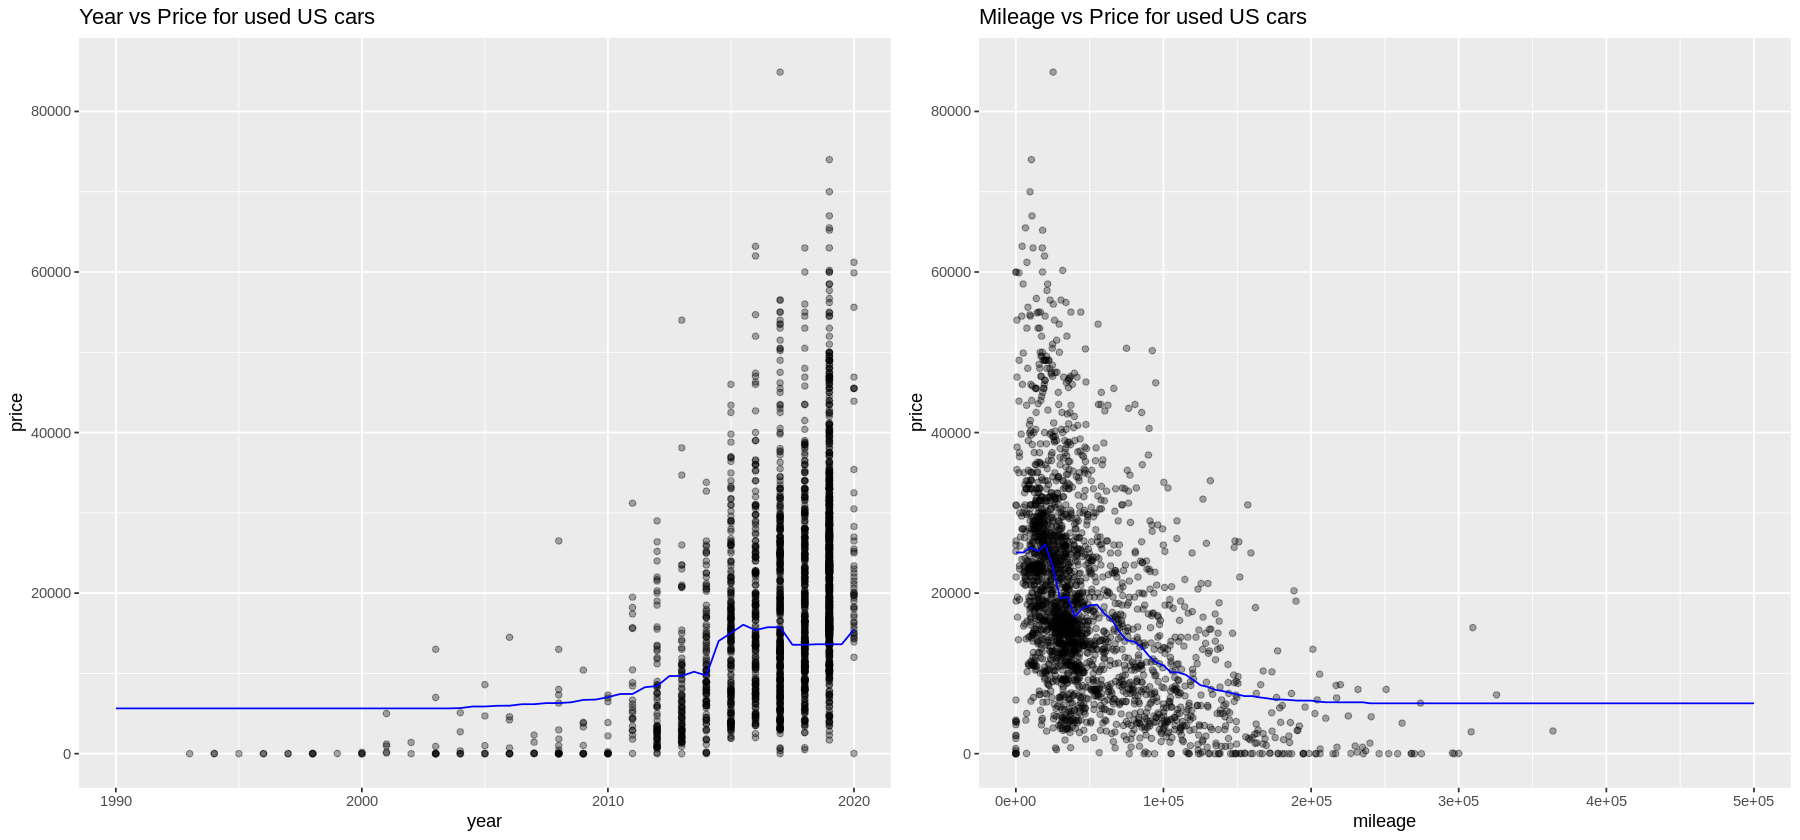

In [11]:
#-----------------------------# Setting the graph size

options(repr.plot.width = 15)

#----------------------------------------------------------------# Below is the KNN model with set k values

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = 201) |>
            set_engine("kknn") |>
            set_mode("regression")

#------------------------------------------------------------------------# Below is the plot for year vs price knn regression

knn_year_pred <- tibble(year = seq(from = 1990, to = 2020, by = 0.5))
knn_year_recipe <- recipe(price ~ year, data = car_train) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())
knn_year_fit <- workflow() |>
           add_recipe(knn_year_recipe) |>
           add_model(knn_spec) |>
           fit(data = car_train)
knn_year_pred <- knn_year_fit |>
            predict(knn_year_pred) |>
            bind_cols(knn_year_pred)
knn_year_plot <- car_all |>
            ggplot(aes(x = year, y = price)) +
            geom_point(alpha = 0.33) +
            geom_line(data = knn_year_pred,
                      mapping = aes(x = year, y = .pred),
                      color = "blue") +
            labs(title = "Year vs Price for used US cars")

#-----------------------------------------------------------------------#Below is price vs mileage knn regression

knn_mi_pred <- tibble(mileage = seq(from = 0, to = 500000, by = 5000))
knn_mi_fit <- workflow() |>
           add_recipe(car_recipe) |>
           add_model(knn_spec) |>
           fit(data = car_train)
knn_mi_pred <- knn_mi_fit |>
            predict(knn_mi_pred) |>
            bind_cols(knn_mi_pred)
knn_mi_plot <- car_all |>
            ggplot(aes(x = mileage, y = price)) +
            geom_point(alpha = 0.33) +
            geom_line(data = knn_mi_pred,
                      mapping = aes(x = mileage, y = .pred),
                      color = "blue") +
            labs(title = "Mileage vs Price for used US cars")

#----------------------------------------------------------------#Below is plotting the graphs beside each other

plot_grid(knn_year_plot, knn_mi_plot, ncol = 2)

This is our KNN regression plots for mileage and year predicting price. The blue line is the predicted cost. KNN regression works better than linear regression because it doesn't predict free cars. We will predict the price of a used car when we enter 2015 into year with 100,000 miles.

In [12]:
#-------------------------------------# Entering our car's values

our_car <- tibble(price = 0,
                  mileage = 100000,
                  year = 2015)

#-----------------------------------------------------------------------------# Setting up the prediction

knn_final_fit <- workflow() |>
           add_recipe(car_recipe) |>
           add_model(knn_spec) |>
           fit(data = car_train)
knn_final_summary <- knn_final_fit |>
                    predict(our_car) |>
                    bind_cols(our_car) |>
                    metrics(truth = price, estimate = .pred) |>
                    filter(.metric == "rmse")
knn_final_summary

Warning message:
“A correlation computation is required, but the inputs are size zero or one and the standard deviation cannot be computed. `NA` will be returned.”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,10994.03


We predict that a 2015 car with 100,000 miles will cost $10,994 US dollars. At glance, it seems like a reasonable result.

**Discussion**

We found that using KNN regression is preferred over linear regression for our data. We used k = 201 and found it by using vfolds of 5. We estimate that a 2015 car will cost $10,994 USD. We expected it to cost more based on inflation at time of study. This dataset recorded data when inflation was less. Our findings can suggest whether a price is "fair"- below the estimate cost- or whether a car's price is a "bad" deal, and it can be used to help people shop for used cars. For the future, we could predict the mileage of a car based on year.

**References**

https://www.kaggle.com/datasets/doaaalsenani/usa-cers-dataset

https://en.wikipedia.org/wiki/Automotive_industry

https://github.com/zhtgeneral/Group-30-Official/blob/main/Group%2030%20Project.ipynb